In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# data analysis and wrangling
# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os
from ipywidgets import interact
import joblib
import shap
shap.initjs()
import warnings
import lightgbm as lgb
import pickle
# machine learning 
from scipy.stats import chi2_contingency
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV,learning_curve
from sklearn.metrics import confusion_matrix,roc_curve,accuracy_score,classification_report,make_scorer,f1_score
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance 
from sklearn.utils.class_weight import compute_class_weight
import MyClassAndFun as MCF

In [2]:
X_train_df=pd.read_csv('X_train.csv')
X_test_df=pd.read_csv('X_test.csv')
y_train=pd.read_csv('y_train.csv')
y_train = y_train['credit_score'] 
y_test=pd.read_csv('y_test.csv')
y_test = y_test['credit_score'] 
class_labels = np.unique(y_test)
class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=y_train)
unique, counts = np.unique(y_test, return_counts=True)
class_counts = dict(zip(unique, counts))

In [3]:
X_train_df.shape

(90000, 23)

In [4]:
# Loading the model back
# KNN_C = joblib.load('KNN_C_model.joblib')
# Random_Forest_C = joblib.load('random_forest_model.joblib')
KNN_C=KNeighborsClassifier(algorithm= 'kd_tree', n_neighbors= 4, p= 1, weights= 'distance',n_jobs = -1)
KNN_C.fit(X_train_df, y_train)
Random_Forest_C=RandomForestClassifier(bootstrap= False, max_depth=None, max_features='log2', min_samples_leaf= 2,
                                       min_samples_split=2, n_estimators= 1800)
Random_Forest_C.set_params(random_state=1, n_jobs = -1,class_weight=dict(enumerate(class_weights)))

Random_Forest_C.fit(X_train_df, y_train)

RandomForestClassifier(bootstrap=False,
                       class_weight={0: 1.1495133726722355,
                                     1: 0.6268675428881877,
                                     2: 1.869741352446245},
                       max_features='log2', min_samples_leaf=2,
                       n_estimators=1800, n_jobs=-1, random_state=1)

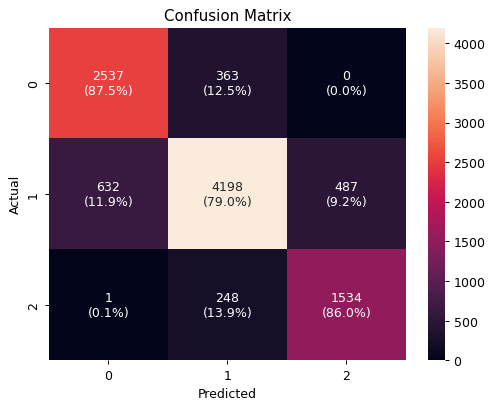

Classification Report for Ansemble Classifier:

              precision    recall  f1-score   support

           0       0.80      0.87      0.84      2900
           1       0.87      0.79      0.83      5317
           2       0.76      0.86      0.81      1783

    accuracy                           0.83     10000
   macro avg       0.81      0.84      0.82     10000
weighted avg       0.83      0.83      0.83     10000



In [5]:
from sklearn.ensemble import VotingClassifier
ensemble = VotingClassifier(estimators=[('Knn', KNN_C),('rf',Random_Forest_C)],voting='soft')
# ensemble.set_params(class_weight=dict(enumerate(class_weights)))
ensemble.fit(X_train_df, y_train)
# Saving model
# joblib.dump(ensemble, 'ensemble_model.joblib')
# Loading the model back
# Random_Forest_C = joblib.load('random_forest_model.joblib')

predictions = ensemble.predict(X_test_df)
confusion = confusion_matrix(y_test, predictions)
report = classification_report(y_test, predictions)

cm = confusion_matrix(y_test, predictions)
cm_norm = confusion_matrix(y_test, predictions, normalize="true")
annot = np.array([f"{i}\n({g:.1%})" for i, g in zip(cm.flatten(), cm_norm.flatten())])
annot = annot.reshape(cm.shape)
fig = plt.figure(dpi=90)
sns.heatmap(cm, annot=annot, fmt="", xticklabels=ensemble.classes_, yticklabels=ensemble.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix")
plt.show()

# Print the classification report
print(f"Classification Report for Ansemble Classifier:\n")
print(report)

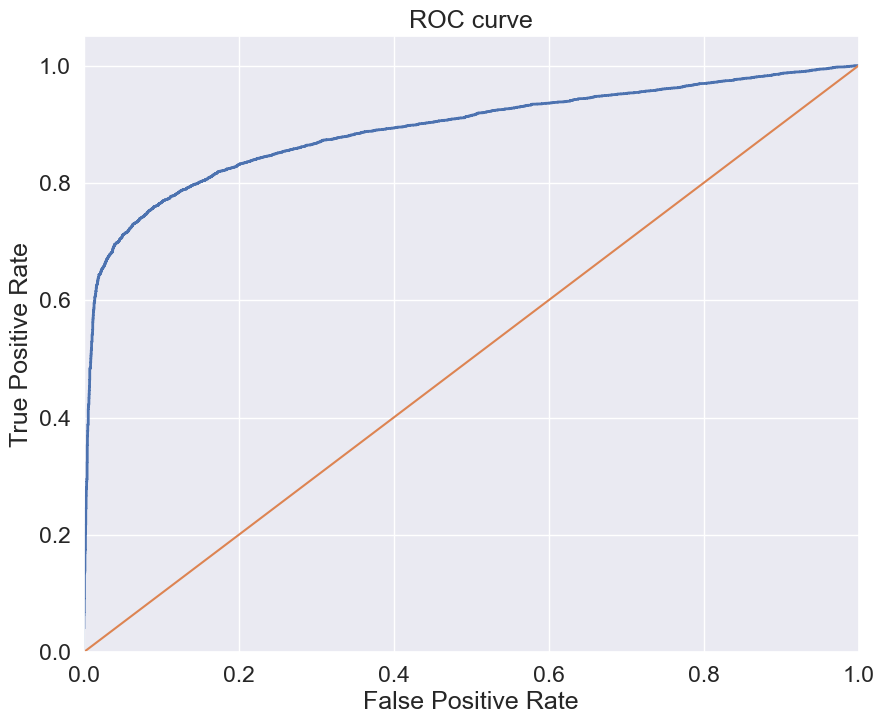

In [6]:
MCF.ROC_curve(ensemble,X_test_df,y_test)

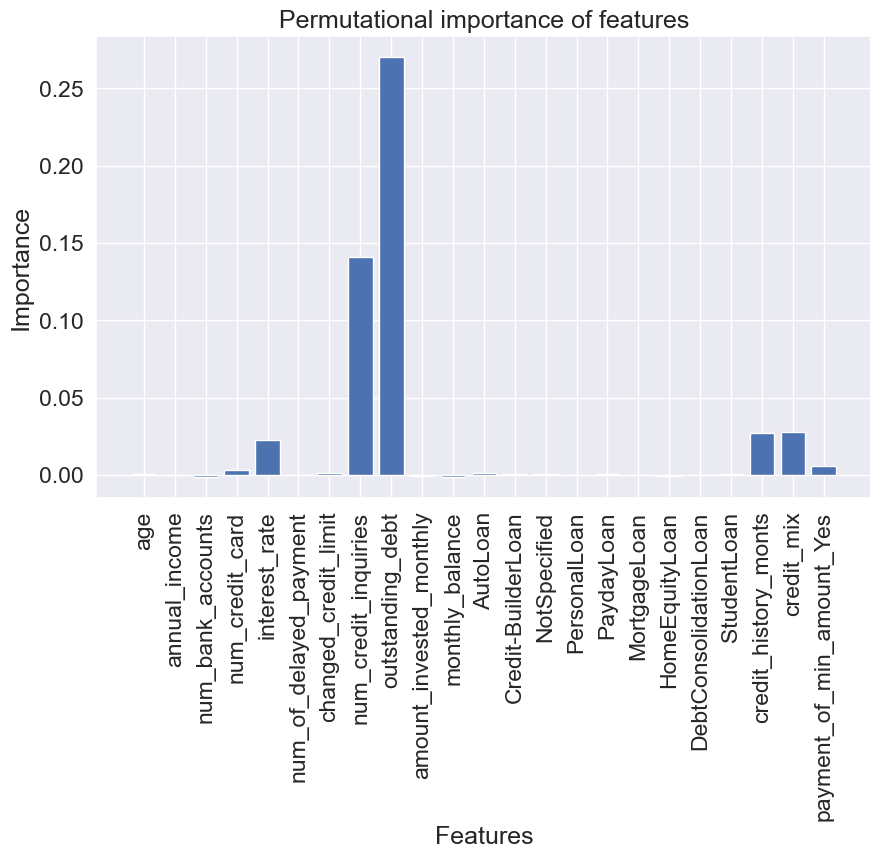

In [7]:
MCF.Perm_import(ensemble,X_test_df,y_test)

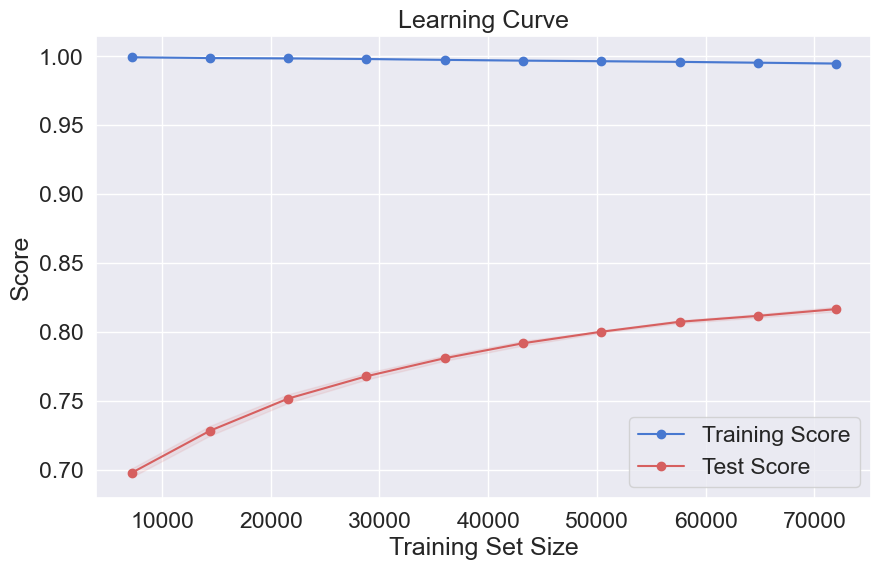

In [8]:
train_sizes = np.linspace(0.1, 1.0, 10)  

MCF.plot_learning_curve(ensemble, X_train_df, y_train, X_test_df, y_test, train_sizes)
